In [1]:
#本文使用svd（）函数实现数据降维
#导入数据集合
import numpy as np

def load_data(filename,splitstyle = "\t"):
    dataset = []
    file = open(filename)
    for line in file.readlines():
        lineArr = line.strip().split(splitstyle)
        m = len(lineArr)
        dataset.append(lineArr[0:m])
    return np.array(dataset,dtype=np.float64)


(1000L, 2L)


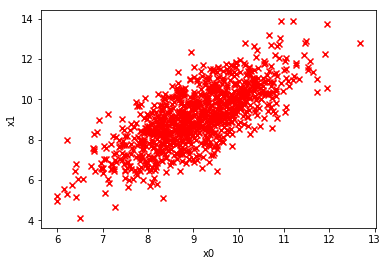

In [2]:
x = load_data("svd/testSet.txt")
print x.shape

import matplotlib.pyplot as plt
#可视化一下数据集合
plt.scatter(x[:,0],x[:,1],marker='x',color = 'r')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()


In [3]:
#feature normalize 特征归一化
def featureNormalize(X):
    X_norm = X
    mu = np.zeros((1,X.shape[1]))
    sigma = np.zeros((1,X.shape[1]))
    
    mu = np.mean(X,axis=0) #mean value of every feature
    sigma = np.std(X,axis=0)#std of every feature
    X_norm = (X - mu) / sigma
    
    return X_norm,mu,sigma 

def SVD(x_norm,k):
    m = x_norm.shape[0]
    x_cov = np.cov(x_norm,rowvar=0)  #[n*n]
    u,s,v = np.linalg.svd(x_cov)     #奇异值分解，s是从大到小排序的对角矩阵，代表奇异值，类似于
                                      #pca中得到的矩阵的特征值，代表数据集合中重要的特征
    u_reduce = u[:,:k] #[n,k]
    x_reduce = x_norm.dot(u_reduce) #[m,n]*[n,k]=[m,k]
    x_recover = x_reduce.dot(u_reduce.T) #[m,k]*[k,n]=[m,n]
    
    return x_reduce,x_recover,s
    

In [4]:
x_norm,x_mean,x_var = featureNormalize(x)
x_reduce,x_recover,s = SVD(x_norm,k=1)

print x_reduce.shape,x_recover.shape

(1000L, 1L) (1000L, 2L)


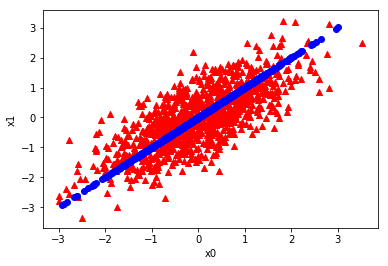

In [5]:
#注意到哦，这里显示的是原来数据标准化x_norm之后的图,以及标准化转变的x_recover
plt.scatter(x_norm[:,0],x_norm[:,1],color = "red",marker = "^")
plt.scatter(x_recover[:,0],x_recover[:,1],color="blue",marker="o")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

In [6]:
#我们现在看一下svd()函数的作用:奇异值分解

a = np.array([[1,1,1,0,0],
              [2,2,2,0,0],
              [1,1,1,0,0],
              [5,5,5,0,0],
              [1,1,0,2,2],
              [0,0,0,3,3],
              [0,0,0,1,1]])
U,S,V = np.linalg.svd(a)

print U.shape,S.shape,V.shape
print S
#在数学公式上，U=[m*m] S=[m*n] V=[n*n]   data = U * S * V
#因为S是对角矩阵，只显示对角元素，所以numpy显示为1维


(7L, 7L) (5L,) (5L, 5L)
[  9.72140007e+00   5.29397912e+00   6.84226362e-01   1.18665567e-15
   3.51083347e-16]


[  6.19213014e+01   3.37204594e+01   4.35823919e+00   7.55850629e-15
   2.23625585e-15]


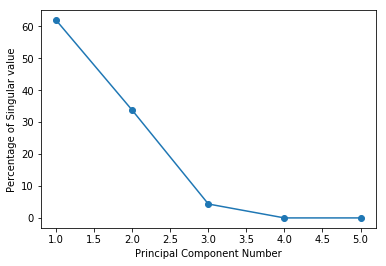

In [7]:
#我们看到前面三个的奇异值相对于后面的两个，数量级相差很大，表明主成分为前3个
#现在通过S的值，判断准则————保留数据中90%的信息
total = np.sum(S)
s_rate = S / total * 100
num = S.shape[0]
print s_rate
plt.plot(np.arange(1,num+1,1),s_rate,"-o")
plt.xlabel("Principal Component Number")
plt.ylabel("Percentage of Singular value")
plt.show()




[0.0, 61.921301416650664, 95.641760811955351, 99.999999999999986, 100.0]


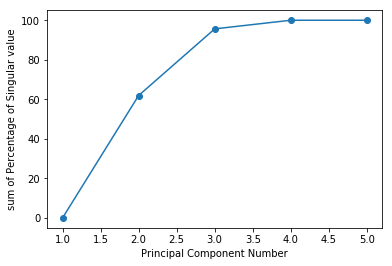

In [8]:
#看一下主成分的累积和
print [np.sum(s_rate[:i]) for i in xrange(num)]
plt.plot(np.arange(1,num+1,1),[np.sum(s_rate[:i]) for i in xrange(num)],"-o")
plt.xlabel("Principal Component Number")
plt.ylabel("sum of Percentage of Singular value")

plt.show()

In [9]:
#我们之后需要s的前3个元素，就能保留矩阵的信息

s3 = np.eye(3) * S[:3]
print s3

A = U[:,:3].dot(s3).dot(V[:3,:])
print A.astype(int)
print "a is equal to A:",A.astype(int)==a

[[ 9.72140007  0.          0.        ]
 [ 0.          5.29397912  0.        ]
 [ 0.          0.          0.68422636]]
[[1 1 1 0 0]
 [2 2 2 0 0]
 [1 1 1 0 0]
 [4 5 4 0 0]
 [1 1 0 2 2]
 [0 0 0 3 3]
 [0 0 0 1 1]]
a is equal to A: [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [False  True False  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


In [10]:
def printMat(inMat, thresh=0.8):
    for i in range(32):
        for k in range(32):
            if float(inMat[i,k]) > thresh:
                print 1,
            else: print 0,
        print ''

def imgCompress(numSV=3, thresh=0.8):
    myl = []
    for line in open('svd/0_5.txt').readlines():
        newRow = []
        for i in range(32):
            newRow.append(int(line[i]))
        myl.append(newRow)
    myMat = np.mat(myl)
    print "****original matrix******"
    printMat(myMat, thresh)
    U,Sigma,VT = np.linalg.svd(myMat) #奇异值分解
    SigRecon = np.mat(np.zeros((numSV, numSV)))
    for k in range(numSV):#construct diagonal matrix from vector
        SigRecon[k,k] = Sigma[k]
    reconMat = U[:,:numSV]*SigRecon*VT[:numSV,:] #重构,只要numSV维
    print "****reconstructed matrix using %d singular values******" % numSV
    printMat(reconMat, thresh)
    


In [11]:
imgCompress(2)
#前后效果一样，但是空间减少
#从原来的需要myMat = 32*32的数组空间
#到reconMat = U(32*2) + Sigma(2) + VT(2*32)

****original matrix******
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 

1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0